# Эксперимент №2: расчет характеристик тандемной сети с узлами  PH/PH/1/N по трём моментам с помощью имитационного моделирования и машинного обучения

В этом эксперименте мы рассчитаем различные характеристики сетей с линейной топологией, в которой случайные величины интервалов поступления и времени обслуживания будут задавать фазовыми распределениями. 

Сначала мы рассчитаем характеристики на заданной сетке статистических параметров с помощью имитационного моделирования сети. Аппроксимацию функцию распределения будем проводить по трем моментов с помощью алгоритма [1]. Затем используем полученные результаты для обучения нейросетевых и других моделей ML, которые сможем использовать для очень быстрой оценки характеристик сетей. Например, такой подход полезен при нахождении решений задач оптимизации топологии, когда характеристики сетей с линейной топологией являются ограничениями в алгоритме ветвей и границ. 


[1] Mary A. Johnson & Michael R. Taaffe (1989) Matching moments to phase distributions: Mixtures of erlang distributions of common order, Communications in Statistics. Stochastic Models, 5:4, 711-743, DOI: 10.1080/15326348908807131


In [4]:
import os
from itertools import product
from collections import namedtuple
import time
from typing import Tuple

from tabulate import tabulate
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import patches
import numpy as np
import pandas as pd

# Подключаем локальные пакеты
from pyqumo.random import Distribution, Exponential, HyperExponential, Erlang
from pyqumo.cqumo.sim import simulate_tandem


from pyqumo.fitting.johnson89 import fit_mern2
from pyqumo.stats import get_cv, get_skewness, get_noncentral_m2, get_noncentral_m3
from pyqumo.random import HyperErlang

# Поключаем пакеты для ML
import math
from sklearn.metrics import r2_score, mean_squared_error, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from scipy import stats

In [5]:
# Настраиваем matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})

In [6]:
def get_std(m1, m2):
    return (m2 - m1**2)**0.5

Определим переменные окружения, которые будут использоваться в эксперименте.

In [7]:
# Нужно ли пересчитывать все, или можно использовать результаты из файлов
FORCE_SIMULATION = False
# SIM_FILE_NAME = '01_tandem_simulation.csv'
SIM_FILE_NAME = 'Tandem_network_with_ph_distribution.csv'
SIM_FILE_DIR = 'data'
SIM_FILE_PATH = os.path.join(SIM_FILE_DIR, SIM_FILE_NAME)

# Зададим число пакетов, передачу которых по сети мы будем моделировать.
# Чем выше это число, тем точнее результаты, но на их получение нужно больше времени.
NUM_PACKETS = 100000

# Цветовая схема для графиков
CMAP_NAME = 'viridis'

In [8]:
COLUMNS = (
    'ArrM1',
    'ArrM2',
    'ArrM3',
    'ArrAvg', 
    'ArrStd', 
    'ArrCv',
    'ArrSkewness'
    'SrvM1',
    'SrvM2',
    'SrvM3',
    'SrvAvg', 
    'SrvStd', 
    'SrvCv',
    'SrvSkewness', 
    'Rho', 
    'NetSize', 
    'Capacity', 
    'NumPackets',
    'DelayAvg', 
    'DelayStd', 
    'DeliveryProb',
)


def save_sim_data(df: pd.DataFrame):
    """
    Сохранить в файл данные о результатах имитационного моделирования.
    """
    if not os.path.exists(SIM_FILE_DIR):
        os.makedirs(SIM_FILE_DIR)
    df.to_csv(SIM_FILE_PATH, index_label='Id')

    
def load_sim_data() -> pd.DataFrame:
    """
    Загрузить данные о резулдьтатах имитационного моделирования.
    """       
    if os.path.exists(SIM_FILE_PATH):
        return pd.read_csv(SIM_FILE_PATH, index_col='Id')
    return pd.DataFrame(columns=COLUMNS, index_col='Id')

sim_data = load_sim_data()
sim_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101424 entries, 0 to 101423
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    101424 non-null  int64  
 1   ArrM1         101424 non-null  float64
 2   ArrM2         101424 non-null  float64
 3   ArrM3         101424 non-null  float64
 4   ArrAvg        101424 non-null  float64
 5   ArrStd        101424 non-null  float64
 6   ArrCv         101424 non-null  float64
 7   ArrSkewness   101424 non-null  float64
 8   SrvM1         101424 non-null  float64
 9   SrvM2         101424 non-null  float64
 10  SrvM3         101424 non-null  float64
 11  SrvAvg        101424 non-null  float64
 12  SrvStd        101424 non-null  float64
 13  SrvCv         101424 non-null  float64
 14  SrvSkewness   101424 non-null  float64
 15  Rho           101424 non-null  float64
 16  NetSize       101424 non-null  float64
 17  Capacity      101424 non-null  float64
 18  NumP

In [5]:
def simulate(
    df: pd.DataFrame, *,
    arr_m1: float,
    arr_m2: float,
    arr_m3: float,
    srv_m1: float,
    srv_m2: float,
    srv_m3: float,
    net_size: int,
    capacity: int,
    num_packets: int,
    force: bool = False
) -> pd.DataFrame:
    """
    Выполнить симуляцию, если результатов нет в `df` или требуется их пересчитать, и вернуть новый `DataFrame`.
    """
    row_df = df[
        (df.ArrM1 == arr_m1) &
        (df.ArrM2 == arr_m2) &
        (df.ArrM3 == arr_m3) &
        (df.ArrAvg == arr_m1) &
        (df.ArrM2 == arr_m2) &
        (df.ArrM3 == arr_m3) &
        (df.SrvM1 == srv_m1) &
        (df.SrvM2 == srv_m2) &
        (df.SrvM3 == srv_m3) &
        (df.NetSize == net_size) &
        (df.Capacity == capacity)]
    
    # Вычислим признаки, которые говорят о необходимости пересчета:
    no_row = len(row_df) == 0
    not_enough_packets = (not no_row) and (row_df.NumPackets.iloc[0] < num_packets)

    # Проверим, нужно ли пересчитать результаты:
    if force or no_row or not_enough_packets:
        arr,_  = fit_mern2(moments=[arr_m1, arr_m2, arr_m3])
        srv,_ = fit_mern2(moments=[srv_m1, srv_m2, srv_m3])
        ret = simulate_tandem(arr, [srv] * net_size, capacity, num_packets)

        row_data = {
            'ArrM1': arr_m1,
            'ArrM2': arr_m2,
            'ArrM3': arr_m3,
            'ArrAvg': arr_m1,
            'ArrStd': get_std(arr_m1, arr_m2),
            'ArrCv': get_cv(arr_m1, arr_m2),
            'ArrSkewness': get_skewness(arr_m1, arr_m2, arr_m3),
            'SrvM1': srv_m1,
            'SrvM2': srv_m2,
            'SrvM3': srv_m3,
            'SrvAvg': srv_m1,
            'SrvStd': get_std(srv_m1, srv_m2),
            'SrvCv': get_cv(srv_m1, srv_m2),
            'SrvSkewness': get_skewness(srv_m1, srv_m2, srv_m3),
            'Rho': arr_m1 / srv_m1,
            'NetSize': net_size,
            'Capacity': capacity,
            'NumPackets': num_packets,
            'DelayAvg': ret.delivery_delays[0].avg,
            'DelayStd': ret.delivery_delays[0].std,
            'DeliveryProb': ret.delivery_prob[0],
        }
        # Если строки еще вообще не было, добавляем ее, а если была - обновляем:
        if no_row:
            df = df.append(row_data, ignore_index=True)
        else:
            df.update(pd.DataFrame(row_data, index=[row_df.index[0]]))

    return df

In [54]:
SAMPLE_NUM = 100000
arr_m1 = np.zeros(SAMPLE_NUM)
arr_cv = np.zeros(SAMPLE_NUM)
arr_m2 = np.zeros(SAMPLE_NUM)
arr_skewness = np.zeros(SAMPLE_NUM)
arr_m3 = np.zeros(SAMPLE_NUM)

srv_m1 = np.zeros(SAMPLE_NUM)
srv_cv = np.zeros(SAMPLE_NUM)
srv_m2 = np.zeros(SAMPLE_NUM)
srv_skewness = np.zeros(SAMPLE_NUM)
srv_m3 = np.zeros(SAMPLE_NUM)

net_size = np.zeros(SAMPLE_NUM)
capacity = np.zeros(SAMPLE_NUM)

for i in range(SAMPLE_NUM):
    arr_m1[i] = np.random.uniform(0, 10)
    arr_cv[i] = np.random.uniform(0.5, 3)
    arr_m2[i] = get_noncentral_m2(arr_m1[i], arr_cv[i])
    arr_skewness[i] = np.random.uniform(arr_cv[i] - 1/arr_cv[i], 100)
    arr_m3[i] = get_noncentral_m3(arr_m1[i], arr_cv[i], arr_skewness[i])

    srv_m1[i] = np.random.uniform(0, 10)
    srv_cv[i] = np.random.uniform(0.5, 3)
    srv_m2[i] = get_noncentral_m2(srv_m1[i], srv_cv[i])
    srv_skewness[i] = np.random.uniform(srv_cv[i] - 1/srv_cv[i], 100)
    srv_m3[i] = get_noncentral_m3(srv_m1[i], srv_cv[i], srv_skewness[i])

    net_size[i] = np.random.randint(1, 20+1)
    capacity[i] = np.random.randint(6, 10+1)

In [14]:
if FORCE_SIMULATION:
    for i in tqdm(range(SAMPLE_NUM)):
        sim_data = simulate(
            sim_data,
            arr_m1=arr_m1[i],
            arr_m2=arr_m2[i],
            arr_m3=arr_m3[i],
            srv_m1=srv_m1[i],
            srv_m2=srv_m2[i],
            srv_m3=srv_m3[i],
            net_size=int(net_size[i]),
            capacity=int(capacity[i]),
            num_packets=NUM_PACKETS,
            force=FORCE_SIMULATION
        )

    print(sim_data.info())
    print(sim_data)

    # Сохраняем результат:
    save_sim_data(sim_data)
else:
    print("Going to use previously computed results. To re-run simulation, set FORCE_SIMULATION = True")

Going to use previously computed results. To re-run simulation, set FORCE_SIMULATION = True


# ПОСТРОЕНИЕ ПРОГНОЗНОЙ МОДЕЛЕЙ С ПОМОЩЬЮ МЕТОДОВ МАШИННОГО ОБУЧЕНИЯ

При расчете многофазных сетей массового обслуживания, мы часто прибегаем к методу имитационного моделирования из-за отсутствия аналитеческих методов расчета. В нашей работе мы использовали модель с фазовыми типами распреления случайных величин для интревалов поступления и времени обслуживания.

Мы получили данные имитационного моделирования `sim_data` объемом 101424 строк.
 
`Tandem_network_with_ph_distribution.csv`

На выходе рассчитывались время межконцевой задержки и вероятность доставки пакетов. К сожалению расчет характеристик производительности сети с помощью имитационного моделирования имеет один существенный минус - это большие затраты по времени. Этот минус оказывает ощутимое влияние в итеративных задач. Например, при проектировании беспроводной сети связи на стадии выбора топологии будущей сети, когда на каждом новом шаге итерации необходимо производить оценку характеристик.

Решением этой проблемы является использования моделей МО для оценки необходимых характеристик беспроводной сети связи.

В качестве **предикторов** моделей будем использовать следующие величины:

- **ArrM1** - Первый момент распределения случайного времени между поступлениями пакетов;
- **ArrM2** - Второй момент распределения случайного времени между поступлениями пакетов;
- **ArrM3** - Третий момент распределения случайного времени между поступлениями пакетов;
- **SrvM1** - Первый момент распределения случайного времени обслуживания;
- **SrvM2** - Второй момент распределения случайного времени обслуживания;
- **SrvM3** - Третий момент распределения случайного времени обслуживания;
- **Capacity** - Размер буфера очередей на фазах;
- **NetSize** - Количество станций в многофазной сети.

Проноз будем строить для выходных данных моделирования - времени межконцевой задержки и вероятности доставки пакетов.

**Цель:** по полученным данным построить **прогнозные модели** для времени межконцевой задержки и вероятности доставки пакетов.

## ПОСТРОЕНИЕ ПРОГНОЗНОЙ МОДЕЛИ ВРЕМЕНИ МЕЖКОНЦЕВОЙ ЗАДЕРЖКИ МНОГОФАЗНОЙ СЕТИ МАСОВОГО ОБСЛУЖИВАНИЯ С ЛИНЕЙНОЙ ТОПОЛОГИЕЙ

Для оценки времени задержек построим _регрессионную модель_.

## ТАБЛИЦА ТРЕНИРОЧНЫХ ДАННЫХ
Мы получили данные симуляции для различных входных параметров. В общей сложности объем выборки составил 101424 строк. Данную выборку будем использовать для обучения будущих моделей.

In [15]:
data = pd.read_csv('data/Tandem_network_with_ph_distribution.csv')
COLUMNS = [
    'ArrM1',
    'ArrM2',
    'ArrM3',
    'SrvM1',
    'SrvM2',
    'SrvM3',
    'NetSize', 
    'Capacity',
    ]

### Предобработка данных

В полученных данных мы случайным образом генерировали величины времени поступления пакетов и времени обслуживания пакетов, задавая моменты $(\mu_1, \mu_2, \mu_3) $  распределения случайным образом. Очевидно, мы сгенерируем данные при очень больших коэффициентах загрузках.

Давайте взглянем на сгенерированные коэффициенты загрузок. 

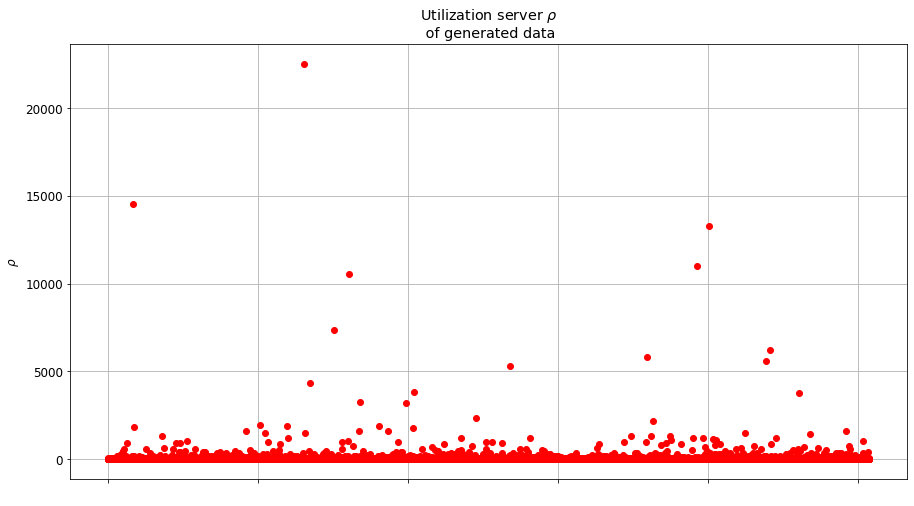

In [16]:
plt.figure(figsize=(15, 8))
plt.title('Utilization server ' r'$\rho$' '\n of generated data')
plt.plot(data['Rho'], 'or')
plt.ylabel(r'Samples');
plt.ylabel(r'$\rho$');
plt.xticks(color='w')
plt.grid()

Как видно из графиков мы имеем значения $\rho$ сильно превышающие диапазон $(0, 1)$. Нецелесообразно использовать такие данные для дальнейшего обучения моделей. Перед тем как начать отсекать строки, вспомни, что узлы нашей многофазной очереди имеют конечный буфер и пакеты при загруженном узле могут теряться. Значит загрузка на первом узле может быть $\rho >> 1$. Поэтому ограничемся  диапазоном $\rho \in (0, 3]$

In [17]:
simulation_data = data[data['Rho'] <= 3]
simulation_data

Unnamed: 0      Id     ArrM1       ArrM2          ArrM3    ArrAvg  \
0                0       0  4.827000  103.562000   49360.519000  4.827000   
1                1       1  2.282000   27.608000    8738.041000  2.282000   
2                2       2  2.018000    6.284000     200.839000  2.018000   
3                3       3  2.083000   24.770000    8301.198000  2.083000   
4                4       4  8.779000  501.970000  431696.824000  8.779000   
...            ...     ...       ...         ...            ...       ...   
101417      101417  101417  3.089434   75.011847    9180.876668  3.089434   
101418      101418  101418  0.753619    3.833045     536.873681  0.753619   
101421      101421  101421  1.416039   18.157332    3018.174624  1.416039   
101422      101422  101422  0.493270    0.842329      18.996446  0.493270   
101423      101423  101423  1.205715    5.854162     279.289564  1.205715   

           ArrStd     ArrCv  ArrSkewness     SrvM1  ...     SrvStd     SrvCv  \
0        8.959000  1.856000    66.873000  4.616000  ...   3.637000  0.788000   
1        4.733000  2.074000    80.861000  5.317000  ...   7.359000  1.384000   
2        1.487000  0.737000    54.492000  9.617000  ...   9.684000  1.007000   
3        4.520000  2.170000    88.408000  1.093000  ...   1.048000  0.959000   
4       20.613000  2.348000    47.934000  5.339000  ...   7.031000  1.317000   
...           ...       ...          ...       ...  ...        ...       ...   
101417   8.091183  2.618986    16.130826  3.293398  ...   6.640206  2.016217   
101418   1.806959  2.397708    89.673216  9.420611  ...  15.489790  1.644245   
101421   4.018975  2.838180    45.393392  7.305316  ...  13.385795  1.832336   
101422   0.773960  1.569039    38.803987  7.459044  ...  15.246675  2.044052   
101423   2.097716  1.739811    28.341999  5.751054  ...  14.964760  2.602090   

        SrvSkewness       Rho  NetSize  Capacity  NumPackets    DelayAvg  \
0         88.605000  1.045711      7.0       8.0    100000.0  103.356466   
1         76.908000  0.429189     17.0       9.0    100000.0  368.032976   
2         33.551000  0.209837      8.0       7.0    100000.0  319.137299   
3         63.711000  1.905764      6.0       6.0    100000.0    9.648775   
4         48.522000  1.644315      2.0       8.0    100000.0   27.751517   
...             ...       ...      ...       ...         ...         ...   
101417    15.111186  0.938069      6.0       8.0    100000.0   88.354207   
101418    20.936585  0.079997     13.0       7.0    100000.0  452.874078   
101421    59.509008  0.193837      4.0       7.0    100000.0  147.498352   
101422    47.477212  0.066130      4.0       8.0    100000.0  171.969494   
101423    36.924737  0.209651     12.0      10.0    100000.0  352.396941   

          DelayStd  DeliveryProb  
0        35.515974      0.898070  
1        93.065457      0.278307  
2        44.052982      0.154662  
3         6.047580      0.976229  
4        23.313290      0.983608  
...            ...           ...  
101417   44.643320      0.505216  
101418  118.417414      0.041703  
101421   66.956343      0.140162  
101422   66.539402      0.051132  
101423  148.839669      0.103115  

[84533 rows x 23 columns]

Приступим к тренировке моделей

In [18]:
train_data, test_data, y_train, y_test = train_test_split(
    simulation_data, simulation_data.loc[:, ['DelayAvg', 'DeliveryProb']], 
    test_size=0.33, 
    random_state=42)
x_train = train_data.loc[:, COLUMNS]
x_test = test_data.loc[:, COLUMNS]

### МЕТРИКИ
Для оценки полученных моделей нам будут необходимы метрики, а именно:

- Стандартное отклонение

In [19]:
def std(x: np.ndarray, y: np.ndarray) -> float:
    """
    Standard deviation between simulation model 
    values and estimates
    """
    return math.sqrt(np.sum((x-y)**2) / (len(x) - 1))

- Коэффициент корреляции

In [20]:
def corr(x: np.ndarray, y: np.ndarray) -> float:
    """
    Correlation coefficient between simulation model 
    values and estimate 
    """
    r = np.corrcoef(x, y)
    return r[0,1]

- и среднеквадратичная ошибка 

```sklearn.metrics.mean_squared_error ```.

### Приступим непосредственно к обучению

-  ## Задача регресии на дереве решений

In [21]:
"""Prepare regression model using Decision Tree algorithm"""
def get_tree_regression_model(x_train, x_text, 
                              y_train, y_test, 
                              max_depth=36, 
                              splitter='best') -> np.ndarray:
    tree = DecisionTreeRegressor(max_depth=max_depth, splitter=splitter)
    tree.fit(x_train, y_train)
    tree_y = tree.predict(x_test)

    print(f'R = {corr(y_test, tree_y):.3f}')
    print(f'STD = {std(y_test, tree_y):.3f}')
    print(f'MSE = {mean_squared_error(y_test, tree_y):.3f}')

    return tree_y

In [22]:
tree_delay_estimate = get_tree_regression_model(x_train, x_test, 
                                                y_train['DelayAvg'], 
                                                y_test['DelayAvg'])

R = 0.989
STD = 25.730
MSE = 661.998


In [23]:
pd.options.mode.chained_assignment = None
# DataFrame для отриосвки графиков
draw_data = test_data
draw_data.loc[:,'DelayAvgTest'] = y_test.loc[:,'DelayAvg']
draw_data.loc[:, 'TreeDelayEst'] = tree_delay_estimate 

In [24]:
draw_data

Unnamed: 0     Id     ArrM1       ArrM2          ArrM3    ArrAvg  \
7565         7565   7565  5.418537   43.711120    1165.034492  5.418537   
50286       50286  50286  3.393043   59.991186    1147.307909  3.393043   
10307       10307  10307  8.739815  160.737921   70456.733585  8.739815   
49566       49566  49566  6.885588  331.359988   78248.465275  6.885588   
29932       29932  29932  0.803596    3.989785      27.389501  0.803596   
...           ...    ...       ...         ...            ...       ...   
14172       14172  14172  0.237850    0.154851       2.199441  0.237850   
98986       98986  98986  9.758233  364.411589  207518.287746  9.758233   
11588       11588  11588  0.852990    1.821557     101.345767  0.852990   
57071       57071  57071  7.937345  104.612205   21817.790661  7.937345   
17713       17713  17713  8.079803  191.102083   74150.285440  8.079803   

          ArrStd     ArrCv  ArrSkewness     SrvM1  ...  SrvSkewness       Rho  \
7565    3.788216  0.699122    14.213061  2.034342  ...    23.213129  2.663533   
50286   6.962646  2.052036     1.821353  6.768030  ...    40.094008  0.501334   
10307   9.184419  1.050871    87.226159  9.268089  ...     3.928279  0.943001   
49566  16.850776  2.447253    15.059610  5.785805  ...    34.414096  1.190083   
29932   1.828666  2.275605     3.075807  3.647968  ...    36.306345  0.220286   
...          ...       ...          ...       ...  ...          ...       ...   
14172   0.313494  1.318034    68.675100  9.016963  ...    63.162545  0.026378   
98986  16.406964  1.681346    44.991670  6.785952  ...    19.628247  1.438005   
11588   1.045928  1.226191    85.583676  5.158159  ...    95.775968  0.165367   
57071   6.450640  0.812695    75.729033  6.723021  ...    34.555733  1.180622   
17713  11.216901  1.388264    50.005769  5.798997  ...    42.268012  1.393310   

       NetSize  Capacity  NumPackets    DelayAvg    DelayStd  DeliveryProb  \
7565       8.0       9.0    100000.0   17.711568    5.594889      0.998010   
50286      7.0      10.0    100000.0  243.549006   40.679441      0.468238   
10307      1.0       7.0    100000.0   44.261498   29.614353      0.863820   
49566     10.0       7.0    100000.0  189.956668   84.657477      0.615088   
29932      5.0      10.0    100000.0  118.705272   57.506625      0.153735   
...        ...       ...         ...         ...         ...           ...   
14172      4.0       8.0    100000.0  218.904166  132.184286      0.018293   
98986      2.0       6.0    100000.0   29.681289   24.648751      0.960350   
11588      7.0       7.0    100000.0  148.293535   24.048615      0.154359   
57071     14.0       9.0    100000.0  331.243610   76.544908      0.778491   
17713     10.0       9.0    100000.0  115.364856   54.697581      0.926624   

       DelayAvgTest  TreeDelayEst  
7565      17.711568     18.459228  
50286    243.549006    253.086364  
10307     44.261498     49.944784  
49566    189.956668    210.382663  
29932    118.705272    127.023309  
...             ...           ...  
14172    218.904166    199.904819  
98986     29.681289     47.707153  
11588    148.293535    145.609523  
57071    331.243610    331.239193  
17713    115.364856    177.159461  

[27896 rows x 25 columns]

На рисунке представлена **диаграмма рассеивания**

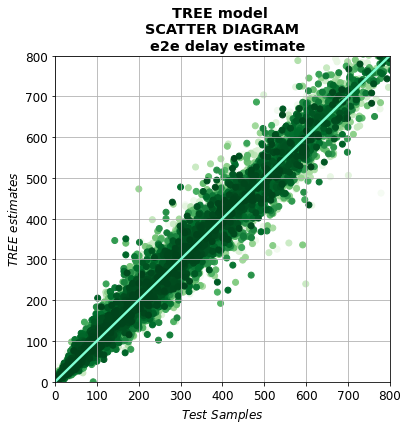

In [46]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.grid()
cm = plt.get_cmap('Greens')
col = [cm(float(i)/(len(y_test))) for i in range((len(y_test)))]
ax.scatter(draw_data['TreeDelayEst'], draw_data['DelayAvgTest'], c=col)
x = np.linspace(0,800,1000)
ax.plot(x, x, linestyle='-', linewidth=2.4, color='aquamarine')
ax.set_title('TREE model \n SCATTER DIAGRAM \n  e2e delay estimate', fontweight='bold')

plt.xlim([0, 800])
plt.ylim([0, 800])

plt.xlabel(r'$Test \ Samples$');
plt.ylabel(r'$TREE \ estimates$');

 Для различных длин тандема сетей представлены гистограммы оценок времени межконцевых задержек тестовой выборки.

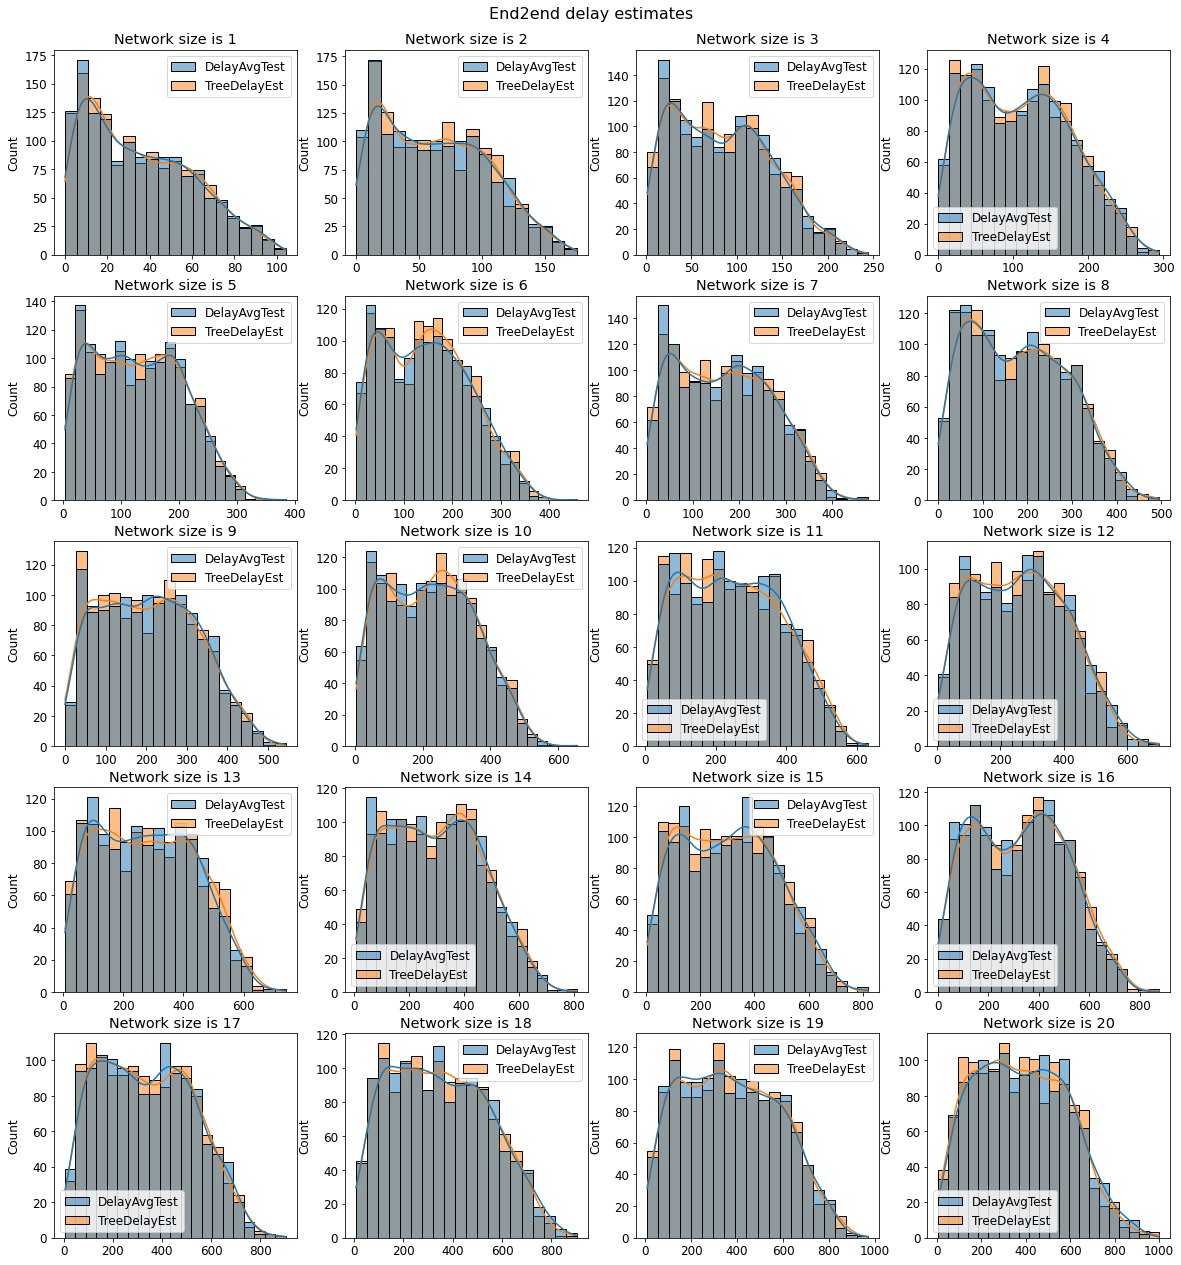

In [27]:
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(20, 20))
fig.suptitle('End2end delay estimates \n', fontsize=16)
plt.subplots_adjust(top=0.95)
for i in net_size:
    draw_hist = draw_data.loc[draw_data['NetSize']==i]
    ax = fig.add_subplot(5, 4, int(i))
    # plt.subplot(figsize=(5, 5))
    ax.title.set_text('Network size is ' + str(int(i)))    
    sns.histplot(draw_hist.loc[:,['DelayAvgTest','TreeDelayEst']], 
                 kde=True)

## 

-  ## Задача регрессии с помощью искуственной нейронной сети на алгоритмае Adam

In [28]:
def normalize(table, stat) -> pd.core.frame.DataFrame:
    """Prepare data for ANN"""
    return (table - stat.loc['mean',:].transpose()) / stat.loc['std',:].transpose()

Необходимо провести нормализацию входных данных перед тем, как непосредственно приступить к обучению нейронной сети 

In [29]:
train_normalize = normalize(x_train, simulation_data.loc[:,COLUMNS].describe())
train_normalize.to_numpy();
test_normalize = normalize(x_test, simulation_data.loc[:,COLUMNS].describe())
test_normalize.to_numpy();

Построем модель будущей сети. Наша сеть состоит из одного скрытого слоя. Для обучения будем использовать алгоритм Адама.

In [30]:
def build_model(size) -> np.ndarray:
    model = keras.Sequential([
        # Input Layer
        layers.Dense(18, activation='sigmoid', 
                     use_bias=True, input_shape=[size]),
        # Hidden Layer
        layers.Dense(18, activation='sigmoid', use_bias=True),
        # Output layer
        layers.Dense(1)])

    optimizer = tf.keras.optimizers.Adam(0.01)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mse'])
    return model

    
model = build_model(len(simulation_data.loc[:,COLUMNS].keys()))

In [31]:
%%time
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
EPOCHS = 1000
keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(train_normalize, y_train['DelayAvg'], 
                    epochs=EPOCHS, 
                    validation_split = 0.3, verbose=0, 
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                             patience=10)])

ann_y = model.predict(test_normalize).flatten()

CPU times: user 43.7 s, sys: 6.06 s, total: 49.8 s
Wall time: 27.6 s


In [32]:
print(f"R = {corr(y_test['DelayAvg'], ann_y):.3f}")
print(f"STD = {std(y_test['DelayAvg'], ann_y):.3f}")
print(f"MSE = {mean_squared_error(y_test['DelayAvg'], ann_y):.3f}")

R = 0.998
STD = 10.746
MSE = 115.468


На рисунке представлена диаграмма рассеивания полученной модели с помощью нейронной сети

In [33]:
# Добавим в draw_data оценку ann_y 
draw_data['AnnDelayEst'] = ann_y

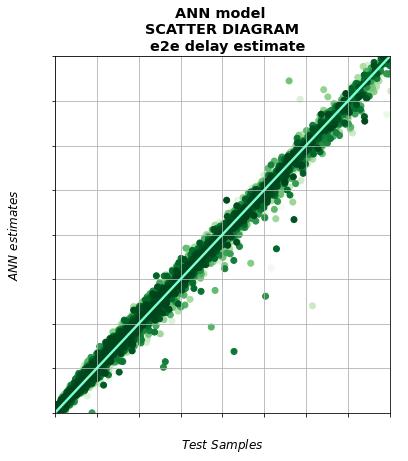

In [43]:
plt.subplots(figsize=(6, 6))
cm = plt.get_cmap('Greens')
col = [cm(float(i)/(len(ann_y))) for i in range((len(ann_y)))]
ax = plt.scatter(draw_data['AnnDelayEst'], 
                 draw_data['DelayAvgTest'], 
                 c=col)
plt.subplots_adjust(top=0.95)
x = np.linspace(0,800,1000)
plt.plot(x, x, 
         linestyle='-', 
         linewidth=2.4, 
         color='aquamarine')
plt.title('ANN model \n SCATTER DIAGRAM \n  e2e delay estimate', fontweight='bold')

plt.xticks(color='w')
plt.yticks(color='w')

plt.xlim([0, 800])
plt.ylim([0, 800])

plt.xlabel(r'$Test \ Samples$')
plt.ylabel(r'$ANN \ estimates$')

plt.grid()


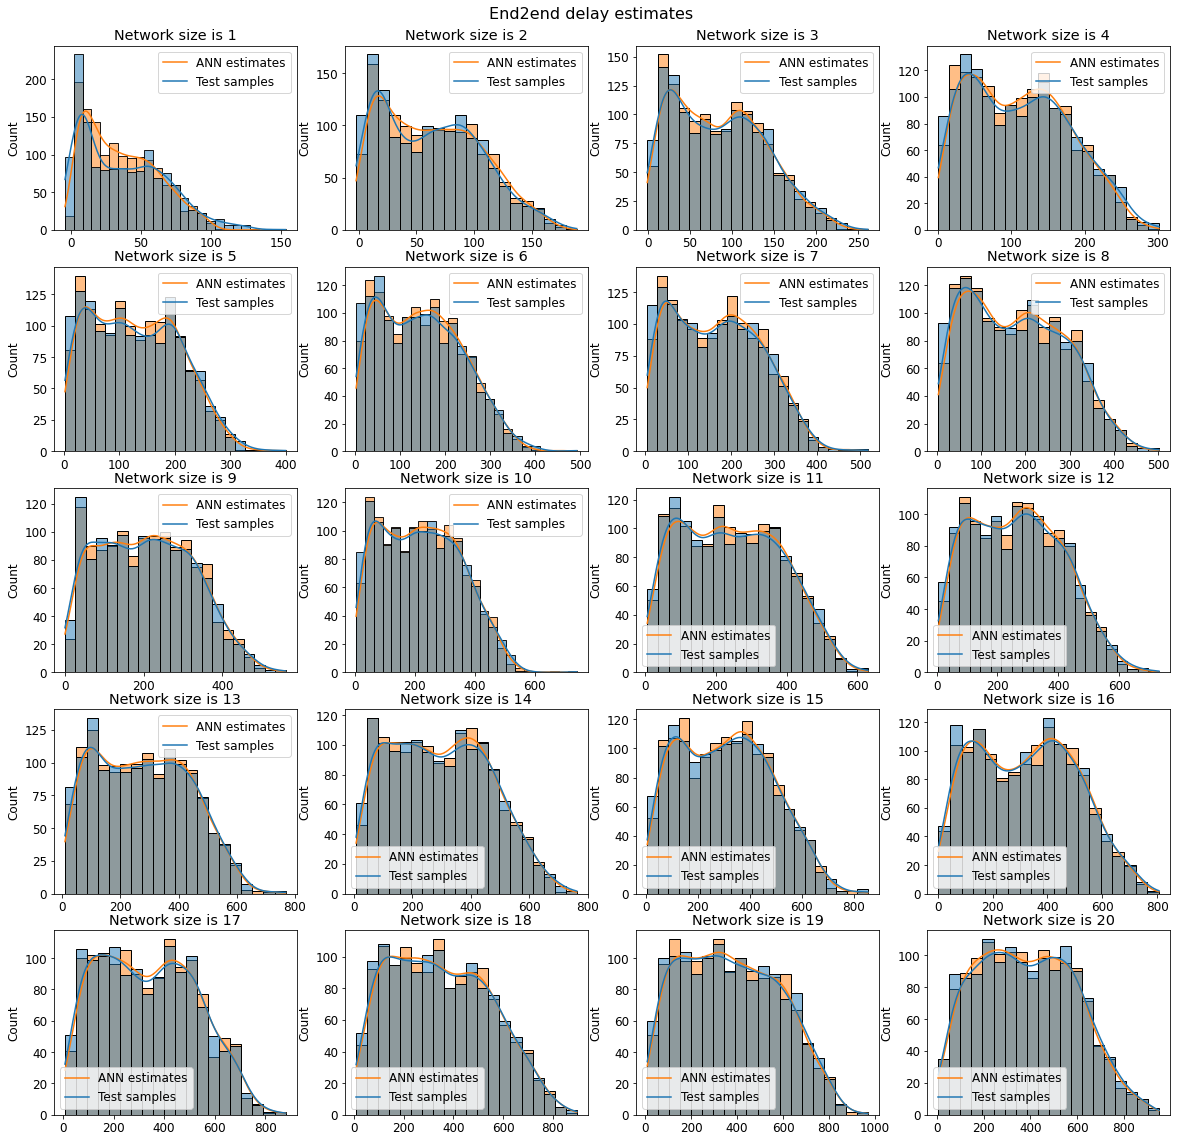

In [35]:
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(20, 18))
fig.suptitle('End2end delay estimates \n', fontsize=16)
plt.subplots_adjust(top=0.95)
for i in net_size:
    draw_hist = draw_data.loc[draw_data['NetSize']==i]
    ax = fig.add_subplot(5, 4, int(i))
    ax.title.set_text('Network size is ' + str(int(i)))    
    sns.histplot(draw_hist.loc[:,['AnnDelayEst','DelayAvgTest']], 
                 kde=True)
    plt.legend(['ANN estimates', 'Test samples'])


## ПОСТРОЕНИЕ ПРОГНОЗНОЙ МОДЕЛИ ВЕРОЯТНОСТИ ДОСТАВКИ ПАКЕТОВ В МНОГОФАЗНОЙ СЕТИ МАСОВОГО ОБСЛУЖИВАНИЯ С ЛИНЕЙНОЙ ТОПОЛОГИЕЙ

В отличии от прогнозной модели времени межконцевой задержки, для которой мы строили регрессионную модель, для модели вероятности доставки нам не критично предсказывать конкретные значения. Гораздо важнее оценивать вероятность относительно граничного значения. Мы заlаемся граничным условием `BOUNDARY` для условия успешной доставки. 

Будем классификать на две группы:
- успешная доставка P <- \[BOUNDARY, 1];
- вероятность потери пакетов P <- [0, BOUNDARY).
        


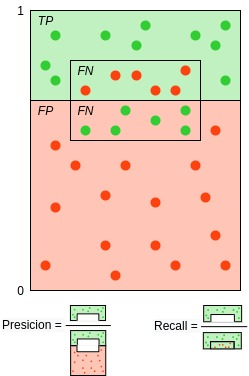

In [36]:
from IPython import display 
display.Image("../experiments/data/clf_metrics.jpg")

### Метрики для задач классификации:

_TP_ is true posistive;

_TN_ is true negative;

_FP_ is false positive;

_FN_ is false negative.

Для оценки моделей будем использовать следущие метрики:    
   
$$
    1. \ Precision = \dfrac{TP}{TP + FP};
$$

$$
    2. \ Recall = \dfrac{TP}{TP + FN};
$$

$$
    3. \ F_1 = 2 * \dfrac{Precision * Recall}{Precision + Recall}. 
$$

- ## Модель задачи классификации на Дереве решений

In [37]:
def get_tree_classif_model(x_train, x_text, 
                           y_train, y_test, 
                           boundary=0.9, 
                           max_depth=10, 
                           splitter='best') -> Tuple[np.array, list, list]:
    binary_train = [1 if i >= boundary else 0 for i in y_train]
    binary_test = [1 if i >= boundary else 0 for i in y_test]
    clf = DecisionTreeClassifier(max_depth=max_depth, splitter=splitter)
    clf = clf.fit(x_train, binary_train)
    prob_estimate = clf.predict(x_test)
    return prob_estimate, binary_train, binary_test

In [38]:
BOUNDARY = 0.9 
prob_clf_train = [1 if i > BOUNDARY else 0 for i in y_train['DeliveryProb']]
prob_clf_test = [1 if i > BOUNDARY else 0 for i in y_test['DeliveryProb']]

tree_prob_estimate, prob_clf_train, prob_clf_test = get_tree_classif_model(x_train, 
                                                                           x_test, 
                                                                           y_train['DeliveryProb'], 
                                                                           y_test['DeliveryProb'],
                                                                           boundary=BOUNDARY)

tree_prob_precision_score = '{:.3f}'.format(precision_score(prob_clf_test, tree_prob_estimate))
tree_prob_recall_score = '{:.3f}'.format(recall_score(prob_clf_test, tree_prob_estimate))
tree_prob_f1_score = '{:.3f}'.format(f1_score(prob_clf_test, tree_prob_estimate))

In [39]:
draw_data['TreeDeliveryProbTest'] = y_test['DeliveryProb']
draw_data['TreeDeliveryProbEst'] = tree_prob_estimate

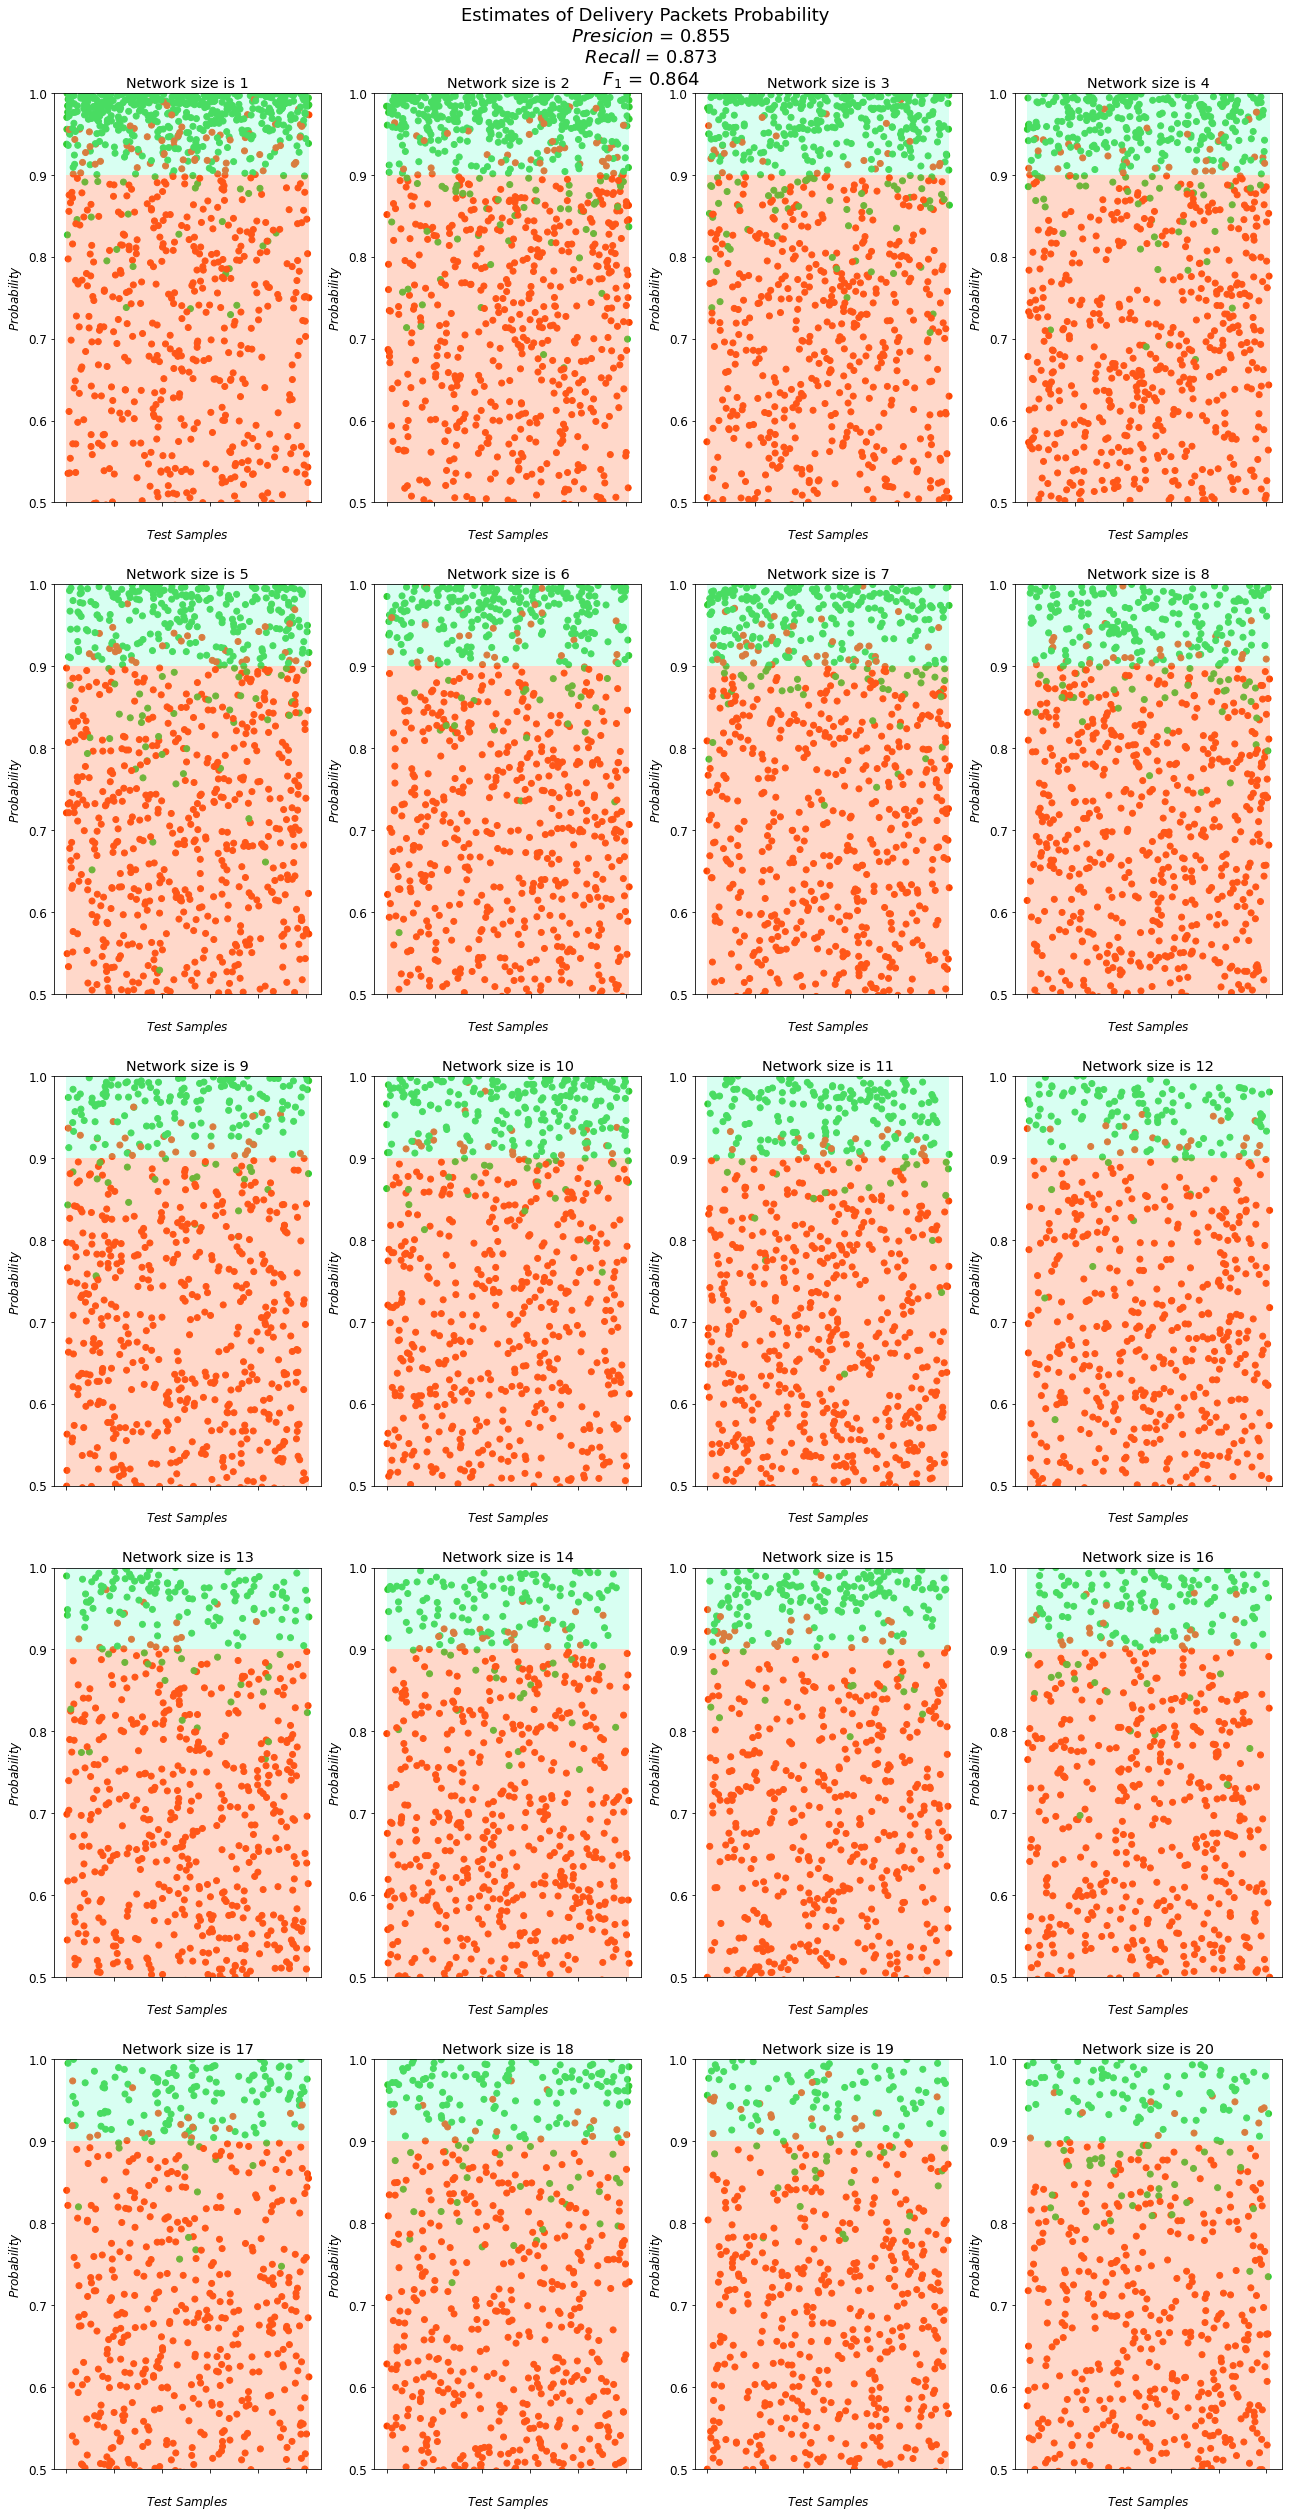

In [40]:
YLIM = [0.5, 1]
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(22, 40))
fig.suptitle(r'Estimates of Delivery Packets Probability' + 
             ' \n $Presicion$ = {}\n $Recall$ = {}\n $F_1$ = {}'.format(
                tree_prob_precision_score, 
                tree_prob_recall_score, 
                tree_prob_f1_score), fontsize=18)
plt.subplots_adjust(top=0.95)
for i in net_size:
    draw_plot = draw_data.loc[draw_data['NetSize']==i]
    ax = fig.add_subplot(5, 4,  int(i))
    
    ax.title.set_text('Network size is ' + str(int(i)))    
    plt.ylim(YLIM)

    prob_color = ['limegreen' if i >BOUNDARY else 'orangered' for i in draw_plot['TreeDeliveryProbEst']]
    ax.scatter(draw_plot['TreeDeliveryProbTest'].index, draw_plot['TreeDeliveryProbTest'], 
               color=prob_color)
    ax.add_patch(
     patches.Rectangle(
        (0, 0),
        width=draw_plot.loc[:,'TreeDeliveryProbTest'].index.max(),
        height=BOUNDARY,
        facecolor = 'coral',
        fill=True,
        alpha=0.3))
    ax.add_patch(
     patches.Rectangle(
        (0, BOUNDARY),
        width=draw_plot.loc[:,'TreeDeliveryProbTest'].index.max(),
        height=1 - BOUNDARY,
        facecolor = 'aquamarine',
        fill=True, alpha=0.3))

    plt.xticks(color='w')   
    ax.set_xlabel(r'$Test \ Samples$')
    ax.set_ylabel(r'$Probability$')

- ## Модель задачи классификации на многослойном персептроне с алгоритмом Adam

In [47]:
def get_mlp_classif_model(x_train, x_test, 
                          y_train, y_test,
                          boundary=0.9, 
                          solver='adam',
                          activation='relu',
                          hidden_layer_sizes=(12, 12)) -> Tuple[np.array, list, list]:
    
    binary_train = [1 if i > boundary else 0 for i in y_train]
    binary_test = [1 if i > boundary else 0 for i in y_test]

    clf = MLPClassifier(solver=solver, activation=activation, 
                    hidden_layer_sizes=hidden_layer_sizes, alpha=0.0001
                    ).fit(x_train, binary_train)
    prob_estimate = clf.predict(x_test)

    return prob_estimate, binary_train, binary_test

In [48]:
from sklearn.neural_network import MLPClassifier

BOUNDARY = 0.9

mlpc_prob_estimate, prob_clf_train, prob_clf_test = get_mlp_classif_model(x_train, x_test, 
                                                                          y_train['DeliveryProb'], 
                                                                          y_test['DeliveryProb'],
                                                                          boundary=0.9, 
                                                                          hidden_layer_sizes=(54, 54))
mlpc_prob_precision_score = '{:.3f}'.format(precision_score(prob_clf_test, mlpc_prob_estimate))
mlpc_prob_recall_score = '{:.3f}'.format(recall_score(prob_clf_test, mlpc_prob_estimate))
mlpc_prob_f1_score = '{:.3f}'.format(f1_score(prob_clf_test, mlpc_prob_estimate))
print(mlpc_prob_precision_score)
print(mlpc_prob_recall_score)
print(mlpc_prob_f1_score)

0.721
0.720
0.720


In [49]:
draw_data['MLPCDeliveryProbEst'] = mlpc_prob_estimate

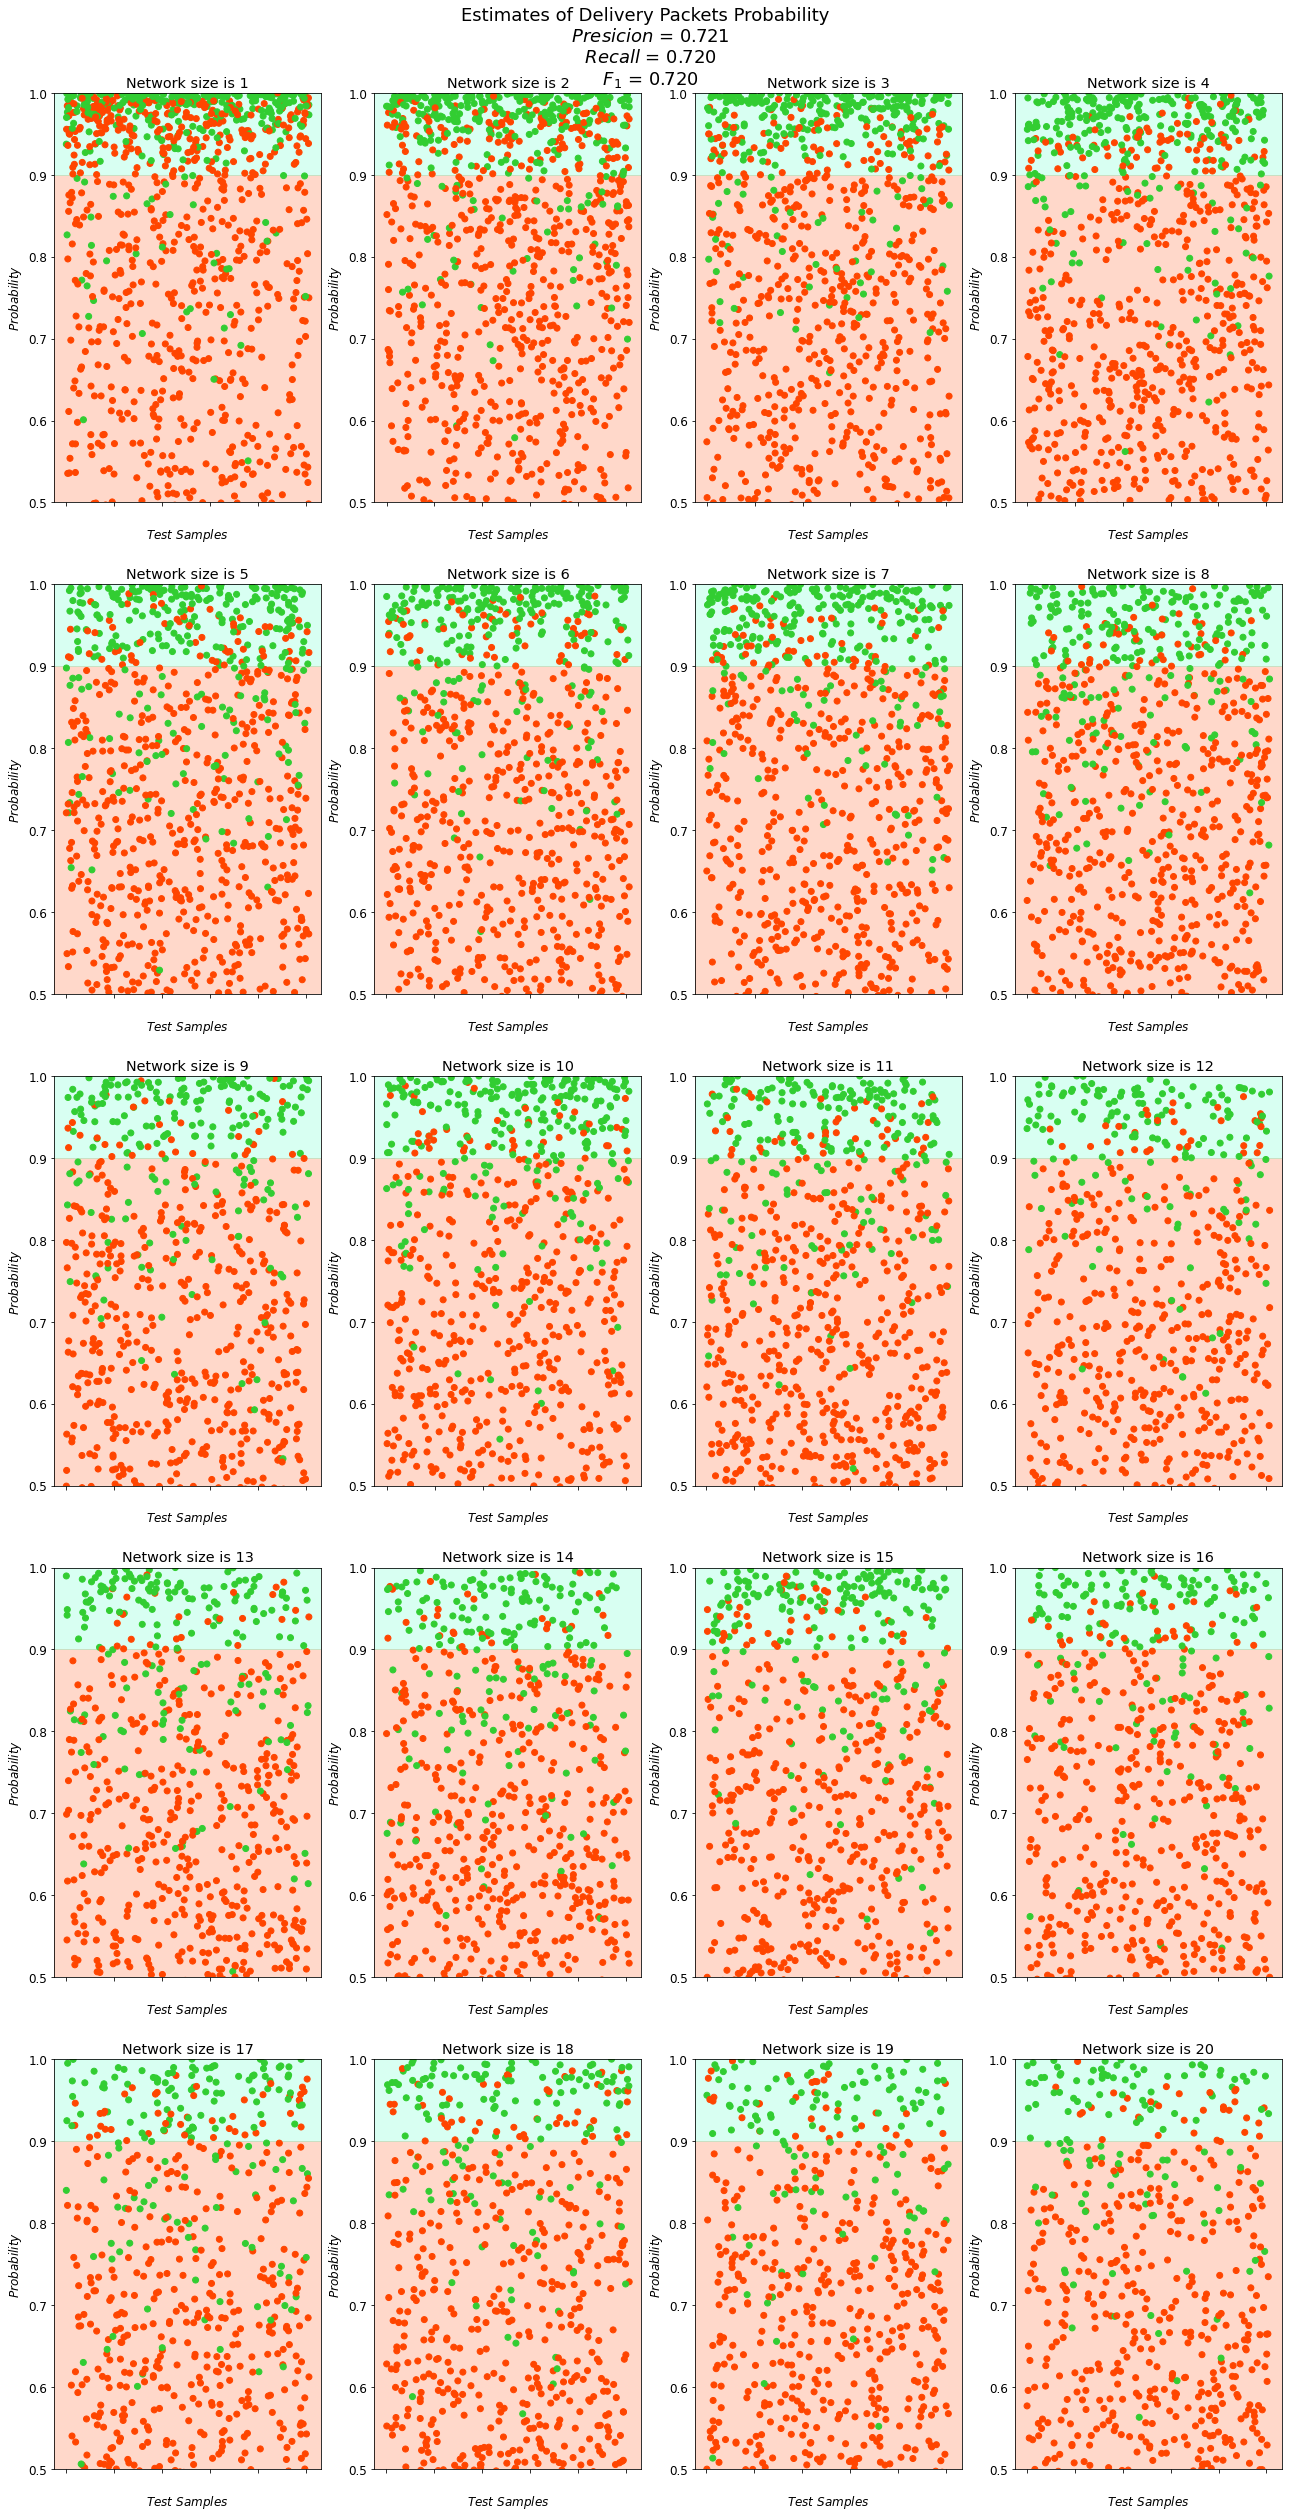

In [58]:
YLIM = [0.5, 1]
net_size = draw_data['NetSize'].unique()
net_size.sort()
fig = plt.figure(figsize=(22, 40))
fig.suptitle(
    'Estimates of Delivery Packets Probability \n $Presicion$ = {}\n $Recall$ = {}\n $F_1$ = {}'.format(
        mlpc_prob_precision_score, 
        mlpc_prob_recall_score, 
        mlpc_prob_f1_score), 
    fontsize=18)
plt.subplots_adjust(top=0.95)
for i in net_size:
    draw_plot = draw_data.loc[draw_data['NetSize']==i]
    ax = fig.add_subplot(5, 4,  int(i))
    ax.axhspan(0, .9, color='coral', zorder=0, alpha=0.3)
    ax.axhspan(.9, 1, color='aquamarine', zorder=0, alpha=0.3)
    ax.title.set_text('Network size is ' + str(int(i)))    
    plt.ylim(YLIM)

    prob_color = ['limegreen' if i >BOUNDARY else 'orangered' for i in draw_plot['MLPCDeliveryProbEst']]
    ax.scatter(draw_plot['TreeDeliveryProbTest'].index, draw_plot['TreeDeliveryProbTest'], 
               color=prob_color)
    plt.xticks(color='w') 
    ax.set_xlabel(r'$Test \ Samples$')
    ax.set_ylabel(r'$Probability$')